In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from tqdm import tqdm

from xgboost import XGBRanker
from sklearn.preprocessing import MinMaxScaler

import time


In [7]:
df = pd.read_csv('train_preprocessed.csv')
df.head()

,srch_id,site_id,visitor_location_country_id,prop_country_id,prop_id,prop_starrating,prop_brand_bool,prop_location_score1,prop_log_historical_price,position,...,srch_booking_window,srch_adults_count,srch_children_count,srch_room_count,srch_saturday_night_bool,random_bool,click_bool,booking_bool,month,relevance
0,1,0,0,1,893,3,1,2.83,4.95,27,...,0,4,0,1,1,1,0,0,4,0.0
1,1,0,0,1,10404,4,1,2.20,5.03,26,...,0,4,0,1,1,1,0,0,4,0.0
2,1,0,0,1,21315,3,1,2.20,4.92,21,...,0,4,0,1,1,1,0,0,4,0.0
3,1,0,0,1,27348,2,1,2.83,4.39,34,...,0,4,0,1,1,1,0,0,4,0.0
4,1,0,0,1,29604,4,1,2.64,4.93,4,...,0,4,0,1,1,1,0,0,4,0.0


In [8]:
X = df
train_groups = X.groupby('srch_id').size().to_frame('size')['size'].to_numpy()

relevances = X['relevance']

X= X.loc[:, ~X.columns.isin(['srch_id','relevance'])]
y = relevances

In [9]:
X = X.drop(['booking_bool','position','random_bool','prop_id','click_bool'], axis=1)


In [10]:
model = XGBRanker(
                  objective='rank:ndcg', 
                  n_estimators=100, 
                  random_state=0,
                  learning_rate=0.1)


model.fit(
    X,
    y,
    group=train_groups,
    eval_metric='ndcg@5',
    eval_set=[(X, y)],
    eval_group=[list(train_groups)],
    verbose=True
)

/home/shreyas/.local/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-ndcg@5:1.00000
[1]	validation_0-ndcg@5:1.00000
[2]	validation_0-ndcg@5:1.00000
[3]	validation_0-ndcg@5:1.00000
[4]	validation_0-ndcg@5:1.00000
[5]	validation_0-ndcg@5:1.00000
[6]	validation_0-ndcg@5:1.00000
[7]	validation_0-ndcg@5:1.00000
[8]	validation_0-ndcg@5:1.00000
[9]	validation_0-ndcg@5:1.00000
[10]	validation_0-ndcg@5:1.00000
[11]	validation_0-ndcg@5:1.00000
[12]	validation_0-ndcg@5:1.00000
[13]	validation_0-ndcg@5:1.00000
[14]	validation_0-ndcg@5:1.00000
[15]	validation_0-ndcg@5:1.00000
[16]	validation_0-ndcg@5:1.00000
[17]	validation_0-ndcg@5:1.00000
[18]	validation_0-ndcg@5:1.00000
[19]	validation_0-ndcg@5:1.00000
[20]	validation_0-ndcg@5:1.00000
[21]	validation_0-ndcg@5:1.00000
[22]	validation_0-ndcg@5:1.00000
[23]	validation_0-ndcg@5:1.00000
[24]	validation_0-ndcg@5:1.00000
[25]	validation_0-ndcg@5:1.00000
[26]	validation_0-ndcg@5:1.00000
[27]	validation_0-ndcg@5:1.00000
[28]	validation_0-ndcg@5:1.00000
[29]	validation_0-ndcg@5:1.00000
[30]	validation_0-nd

XGBRanker(base_score=None, booster=None, callbacks=None, colsample_bylevel=None,
          colsample_bynode=None, colsample_bytree=None,
          early_stopping_rounds=None, enable_categorical=False,
          eval_metric=None, feature_types=None, gamma=None, gpu_id=None,
          grow_policy=None, importance_type=None, interaction_constraints=None,
          learning_rate=0.1, max_bin=None, max_cat_threshold=None,
          max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
          max_leaves=None, min_child_weight=None, missing=nan,
          monotone_constraints=None, n_estimators=100, n_jobs=None,
          num_parallel_tree=None, objective='rank:ndcg', predictor=None, ...)

<Axes: >

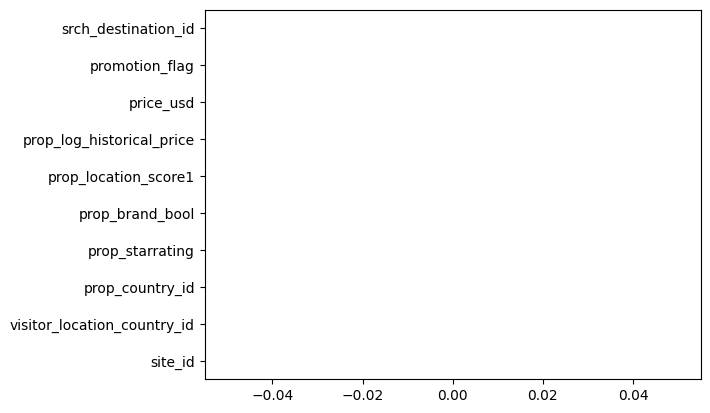

In [11]:
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')

In [12]:
test_df = pd.read_csv('test_preprocessed.csv')

In [13]:
def sort_properties(srch_id, scores, prop_ids):
    sorted_group = pd.DataFrame(columns=['srch_id', 'prop_id', 'scores'])
    sorted_group['srch_id'] = len(scores)*[srch_id]
    sorted_group['prop_id'] = prop_ids.values
    sorted_group['scores'] = scores
    sorted_group = sorted_group.sort_values(by='scores', ascending=False)
    return sorted_group 

def recommend_properties(model, data):
    result = pd.DataFrame(columns=['srch_id', 'prop_id', 'scores'])
    df_list = []
    grouped_data = data.groupby('srch_id')
    for group_name, group in tqdm(grouped_data):
        scores = model.predict(group.loc[:, ~group.columns.isin(['srch_id','prop_id'])])
        sorted_group = sort_properties(group_name, scores, group['prop_id'])
        df_list.append(sorted_group)
    result = pd.concat(df_list)
    return result

In [14]:
X.columns

Index(['site_id', 'visitor_location_country_id', 'prop_country_id',
       'prop_starrating', 'prop_brand_bool', 'prop_location_score1',
       'prop_log_historical_price', 'price_usd', 'promotion_flag',
       'srch_destination_id', 'srch_length_of_stay', 'srch_booking_window',
       'srch_adults_count', 'srch_children_count', 'srch_room_count',
       'srch_saturday_night_bool', 'month'],
      dtype='object')

In [15]:
test_df.columns

Index(['srch_id', 'site_id', 'visitor_location_country_id', 'prop_country_id',
       'prop_id', 'prop_starrating', 'prop_brand_bool', 'prop_location_score1',
       'prop_log_historical_price', 'price_usd', 'promotion_flag',
       'srch_destination_id', 'srch_length_of_stay', 'srch_booking_window',
       'srch_adults_count', 'srch_children_count', 'srch_room_count',
       'srch_saturday_night_bool', 'month'],
      dtype='object')

In [16]:
start = time.time()
recommendations = recommend_properties(model, test_df)
end = time.time()
print(f'Total Time for validation prediction:{end - start}')
submission = recommendations.drop(columns=['scores'])
submission.to_csv(f'xgbranker_predictions.csv', index=False)

  8%|▊         | 15804/199549 [01:32<17:55, 170.81it/s]


KeyboardInterrupt: 